In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv


In [55]:
# Import training data
train = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')

# Print few random entries
train.sample(5)

,text,label
14853,i watched her tears fell i really feel so hear...,0
1505,i now feel like i look really ugly some people...,0
3307,i wasnt mad at him i was mad at j for making m...,0
961,i guess im just feeling a little rebellious,3
10893,i am sure everyone of us felt that feeling at ...,3


# EDA

In [4]:
# Checking the number of rows and columns
print("The DataFrame has " + str(train.shape[0]) + " samples and " + str(train.shape[1]) + " columns")

The DataFrame has 16000 samples and 2 columns


In [6]:
# Check duplicates
print("Duplicate entries in the dataset: " + str(train.duplicated().sum()))

Duplicate entries in the dataset: 1


In [9]:
train = train.drop_duplicates()

In [10]:
# Check duplicates
print("Duplicate entries in the dataset: " + str(train.duplicated().sum()))

Duplicate entries in the dataset: 0


In [12]:
# Check null values and data type of each column
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15999 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15999 non-null  object
 1   label   15999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.0+ KB


In [15]:
#Some Libraries
import warnings
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict )
train.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [57]:
import plotly.express as px
train['length_of_text'] = [len(i.split(' ')) for i in train['text']]

fig = px.histogram(train['length_of_text'], marginal='box',
                   labels={"value": "Length of the Text"})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Length of the Texts',
                  title_x=0.5, title_font=dict(size=22))
fig.show()


In [58]:
FreqOfWords = train['text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text='Frequency of the Words in the Train Dataset',
                  title_x=0.5, title_font=dict(size=22)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

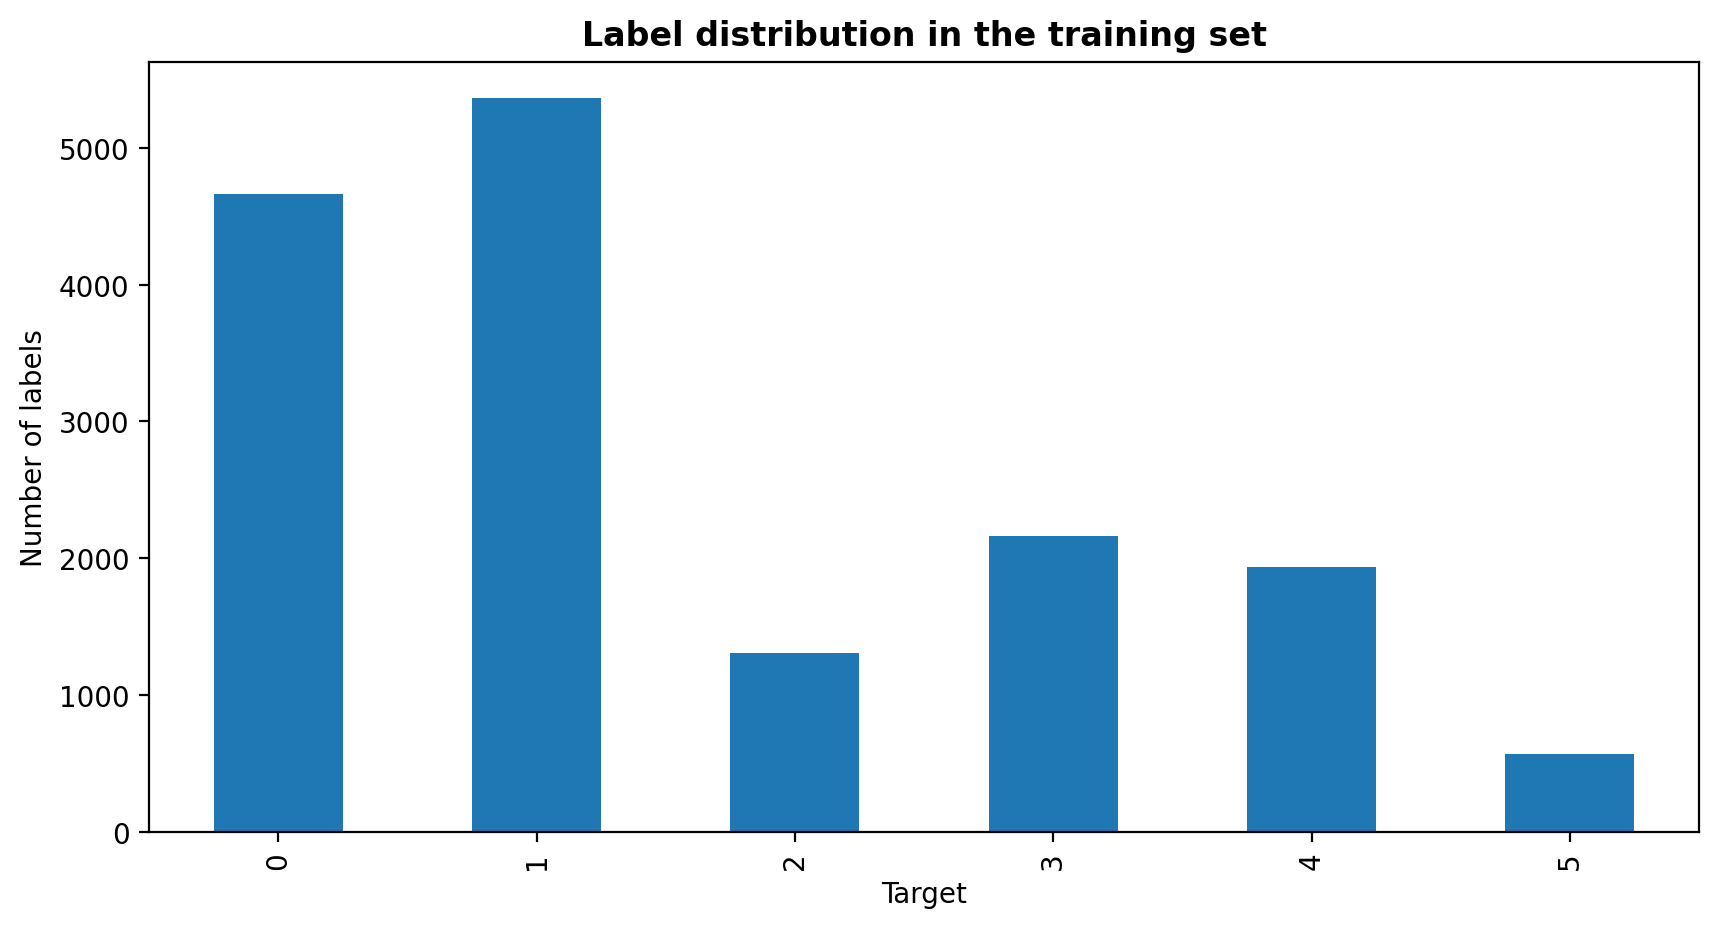

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
# Check target balance
train['label'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Label distribution in the training set', fontweight="bold")
plt.xlabel('Target')
plt.ylabel('Number of labels')
plt.show()

In [20]:
import re
from nltk.corpus import stopwords

# Create a stopwords set adding some personal 'words'
stopwords_english = set(stopwords.words('english'))
my_stopwords = set(["http", "'s", "n't", "'m", "'re", "'ve"])
stopwords_english.update(my_stopwords)

def preprocess_review(text):
    # Convert to lower case
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Split text into tokens
    tokens = text.split()

    # Filter tokens
    clean_tokens = [tok for tok in tokens if tok not in stopwords_english and len(tok) > 1]

    # Join tokens into a string
    clean_text = ' '.join(clean_tokens)

    return clean_text

In [27]:
# Get one review as sample
sample = train['text'][20]

print('ORIGINAL REVIEW:   ' + sample + '\n')
print('---------------------------------------------------------------------------- \n')
print('WITH PROCESSING:    ' + preprocess_review(sample))

ORIGINAL REVIEW:   i feel irritated and rejected without anyone doing anything or saying anything

---------------------------------------------------------------------------- 

WITH PROCESSING:    feel irritated rejected without anyone anything saying anything


In [28]:
%%time

# Preprocess training data adding new column
train["clean_text"] = train["text"].apply(preprocess_review)

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 175 ms


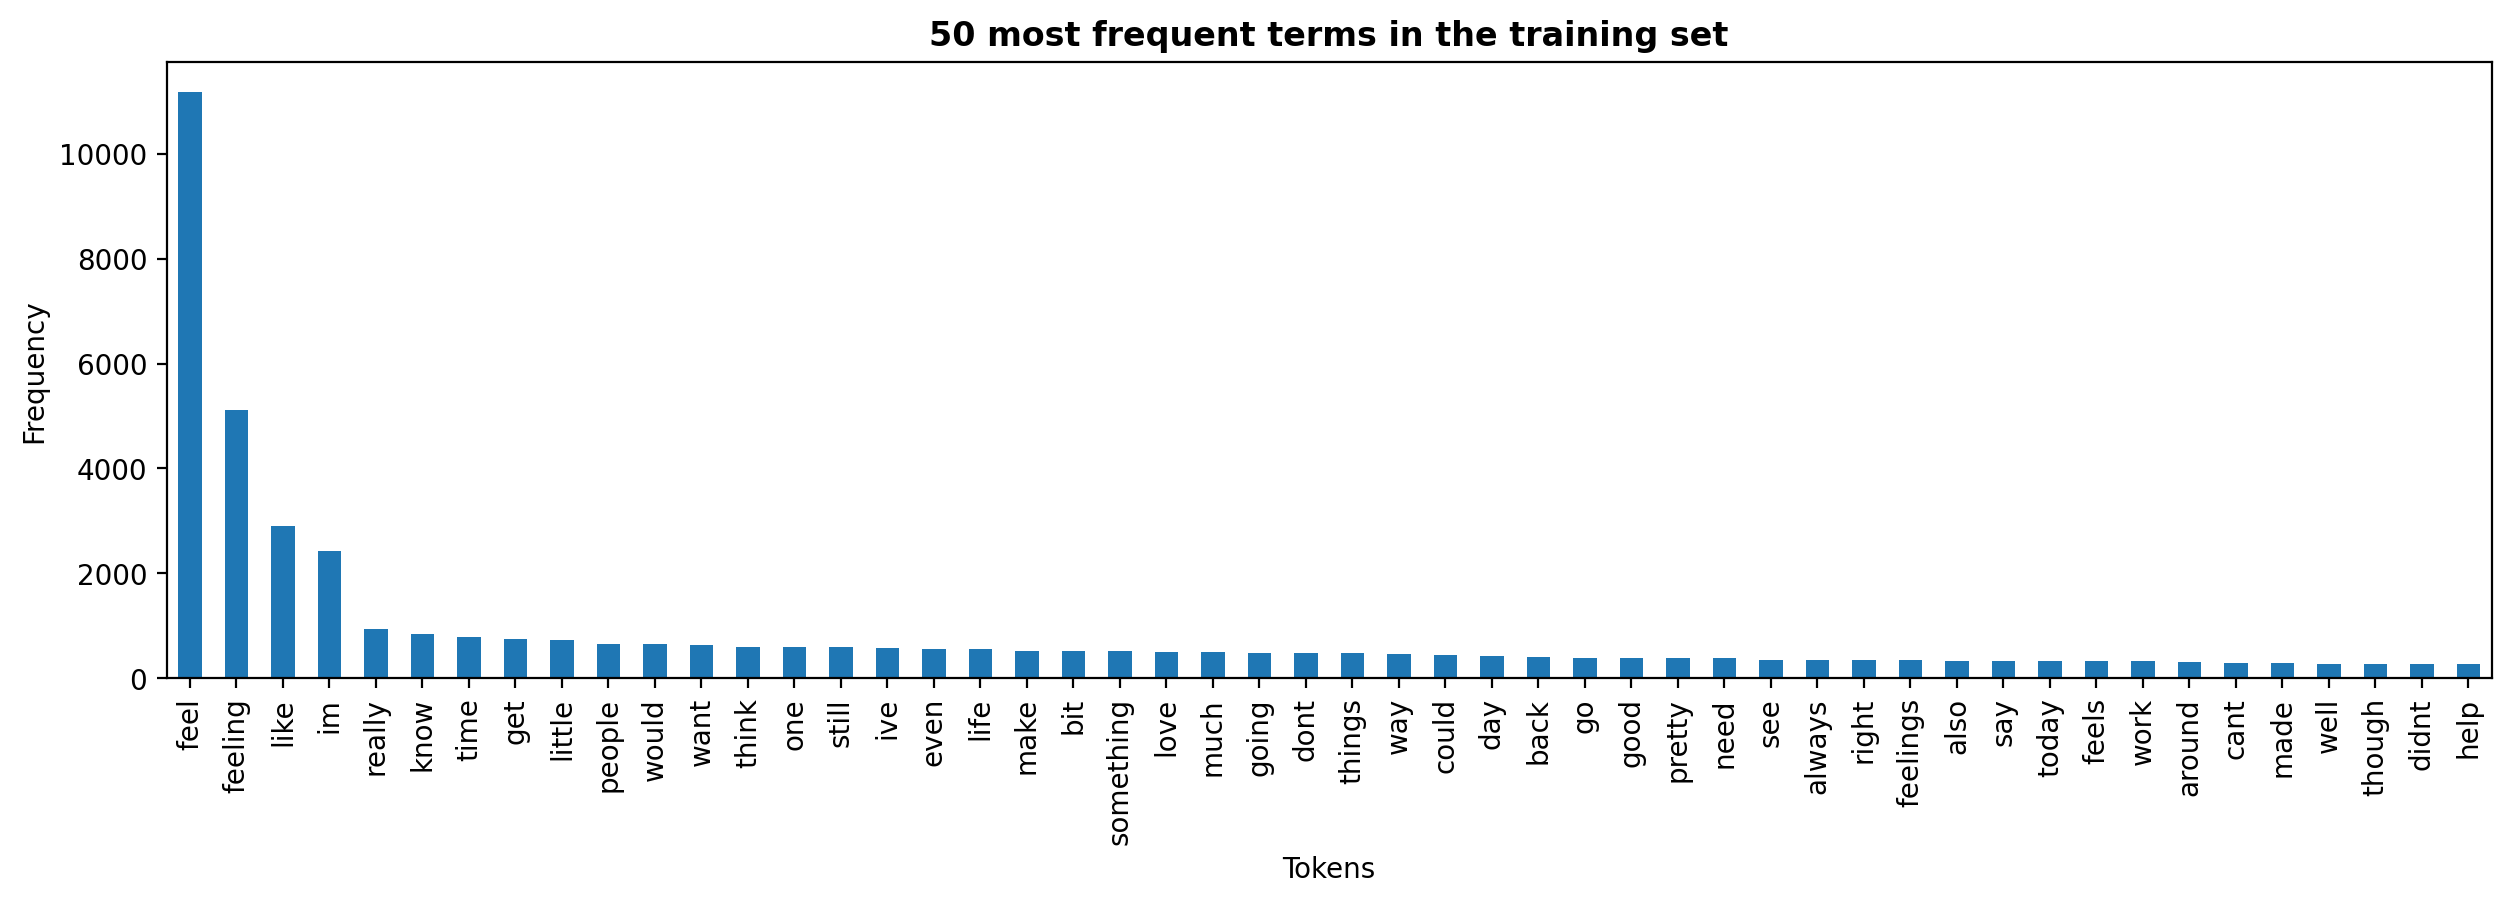

In [29]:
# Get 50 most frequent words in the training set
frequent_words = pd.Series(' '.join(train.clean_text).split()).value_counts()[:50]
frequent_words.plot.bar(figsize=(15,4))
plt.title('50 most frequent terms in the training set', fontweight="bold")
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.show()

In [30]:
# I found that the variable 'frequent_words' takes up about 6 Gb of RAM! Better clean it up!
import gc

del frequent_words

gc.collect()

10578

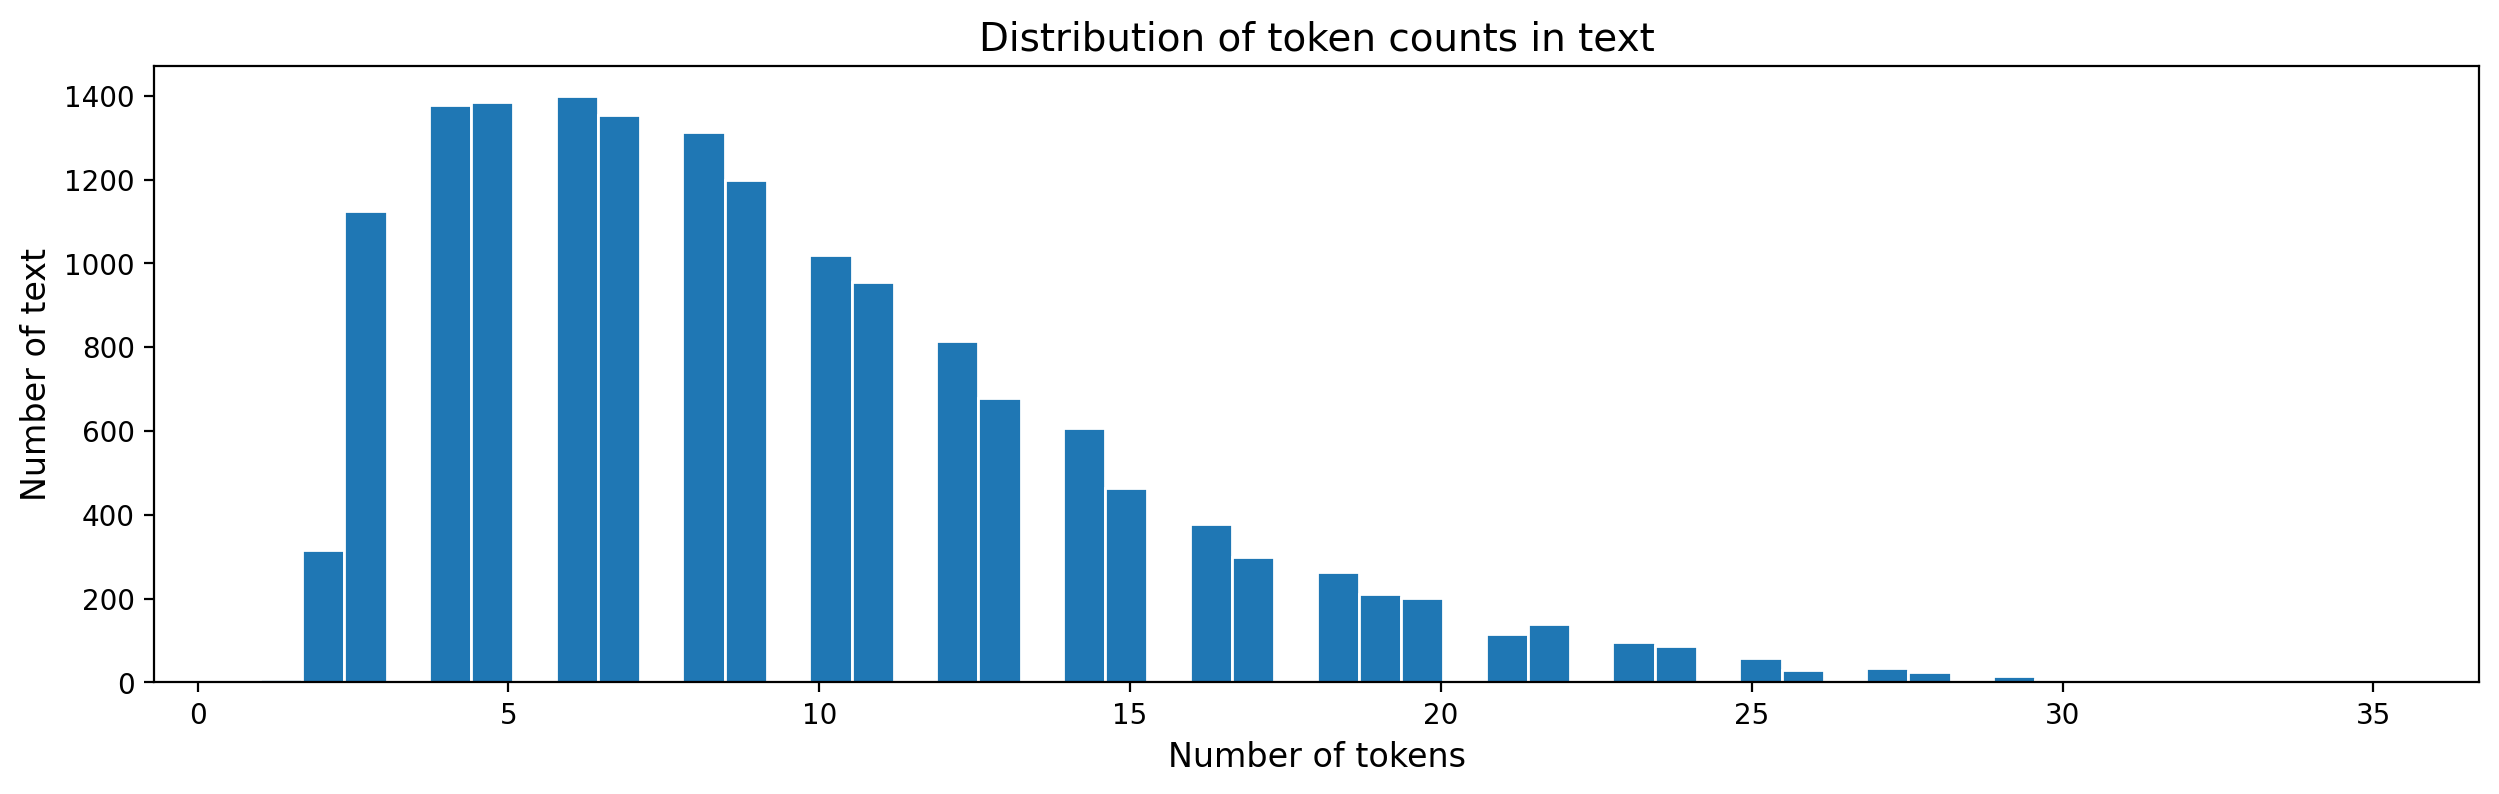

In [32]:
# Plot the number of tokens in cleaned reviews
plt.figure(figsize=(15,4))
plt.hist(train['clean_text'].apply(lambda x:len(x.split())), bins=50, edgecolor='white')
plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of text',fontsize=12)
plt.title('Distribution of token counts in text', fontsize=14)
plt.show()

In [35]:
# Remove original text column
train = train.drop(columns=['text'])

# Get few entries to check operation
train.head()

,label,description,clean_text
0,0,sadness,didnt feel humiliated
1,0,sadness,go feeling hopeless damned hopeful around some...
2,3,anger,im grabbing minute post feel greedy wrong
3,2,love,ever feeling nostalgic fireplace know still pr...
4,3,anger,feeling grouchy


# Test Set

In [33]:
# Import training data
test = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

# Print a random row
test.sample()

,text,label
1847,i am not feeling as terrific as i have been,1


In [34]:
%%time

# Preprocess training data adding new column
test["clean_text"] = test["text"].apply(preprocess_review)

# Remove original text column
test = test.drop(columns=['text'])

# Get few entries to check cleaning operation
test.head()

CPU times: user 25.9 ms, sys: 1.08 ms, total: 26.9 ms
Wall time: 26.1 ms


,label,clean_text
0,0,im feeling rather rotten im ambitious right
1,0,im updating blog feel shitty
2,0,never make separate ever want feel like ashamed
3,1,left bouquet red yellow tulips arm feeling sli...
4,0,feeling little vain one


# Split the data

In [36]:
# Create X, y arrays
from sklearn.model_selection import train_test_split

# Training data
X_train = train["clean_text"].values
y_train = train["label"].values

# Split into train/test sets
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Test data
X_te = test["clean_text"].values

print("Training data:", X_tr.shape, y_tr.shape)
print("Validation data:", X_va.shape, y_va.shape)
print("Test data:", X_te.shape)

Training data: (12799,) (12799,)
Validation data: (3200,) (3200,)
Test data: (2000,)


# Model part

In [37]:
%%time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_tr)

max_seq_length = 250

X_tr_seq = tokenizer.texts_to_sequences(X_tr)
X_tr_seq = pad_sequences(X_tr_seq, maxlen=max_seq_length)

X_va_seq = tokenizer.texts_to_sequences(X_va)
X_va_seq = pad_sequences(X_va_seq, maxlen=max_seq_length)

X_te_seq = tokenizer.texts_to_sequences(X_te)
X_te_seq = pad_sequences(X_te_seq, maxlen=max_seq_length)

CPU times: user 508 ms, sys: 3.46 ms, total: 511 ms
Wall time: 510 ms


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=250))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=128)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['acc']
                 )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          2560000   
                                                                 
 conv1d (Conv1D)             (None, 248, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 64)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 124, 128)         66048     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 124, 128)         512       
 ormalization)                                                   
                                                        

In [40]:
%%time

history = model.fit(X_tr_seq,
                    y_tr,
                    validation_data=(X_va_seq, y_va),
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                   )

Epoch 1/15
200/200 [==============================] - 104s 472ms/step - loss: 2.1726 - acc: 0.1916 - val_loss: 1.6859 - val_acc: 0.2891
Epoch 2/15
200/200 [==============================] - 93s 464ms/step - loss: 1.7666 - acc: 0.3127 - val_loss: 1.6248 - val_acc: 0.2962
Epoch 3/15
200/200 [==============================] - 93s 465ms/step - loss: 1.2540 - acc: 0.5468 - val_loss: 1.2346 - val_acc: 0.5644
Epoch 4/15
200/200 [==============================] - 93s 465ms/step - loss: 0.8051 - acc: 0.7311 - val_loss: 0.9417 - val_acc: 0.6897
Epoch 5/15
200/200 [==============================] - 93s 465ms/step - loss: 0.5374 - acc: 0.8325 - val_loss: 0.7565 - val_acc: 0.7469
Epoch 6/15
200/200 [==============================] - 93s 464ms/step - loss: 0.3796 - acc: 0.8877 - val_loss: 0.7042 - val_acc: 0.7678
Epoch 7/15
200/200 [==============================] - 93s 465ms/step - loss: 0.2866 - acc: 0.9215 - val_loss: 0.5220 - val_acc: 0.8375
Epoch 8/15
200/200 [==============================] - 

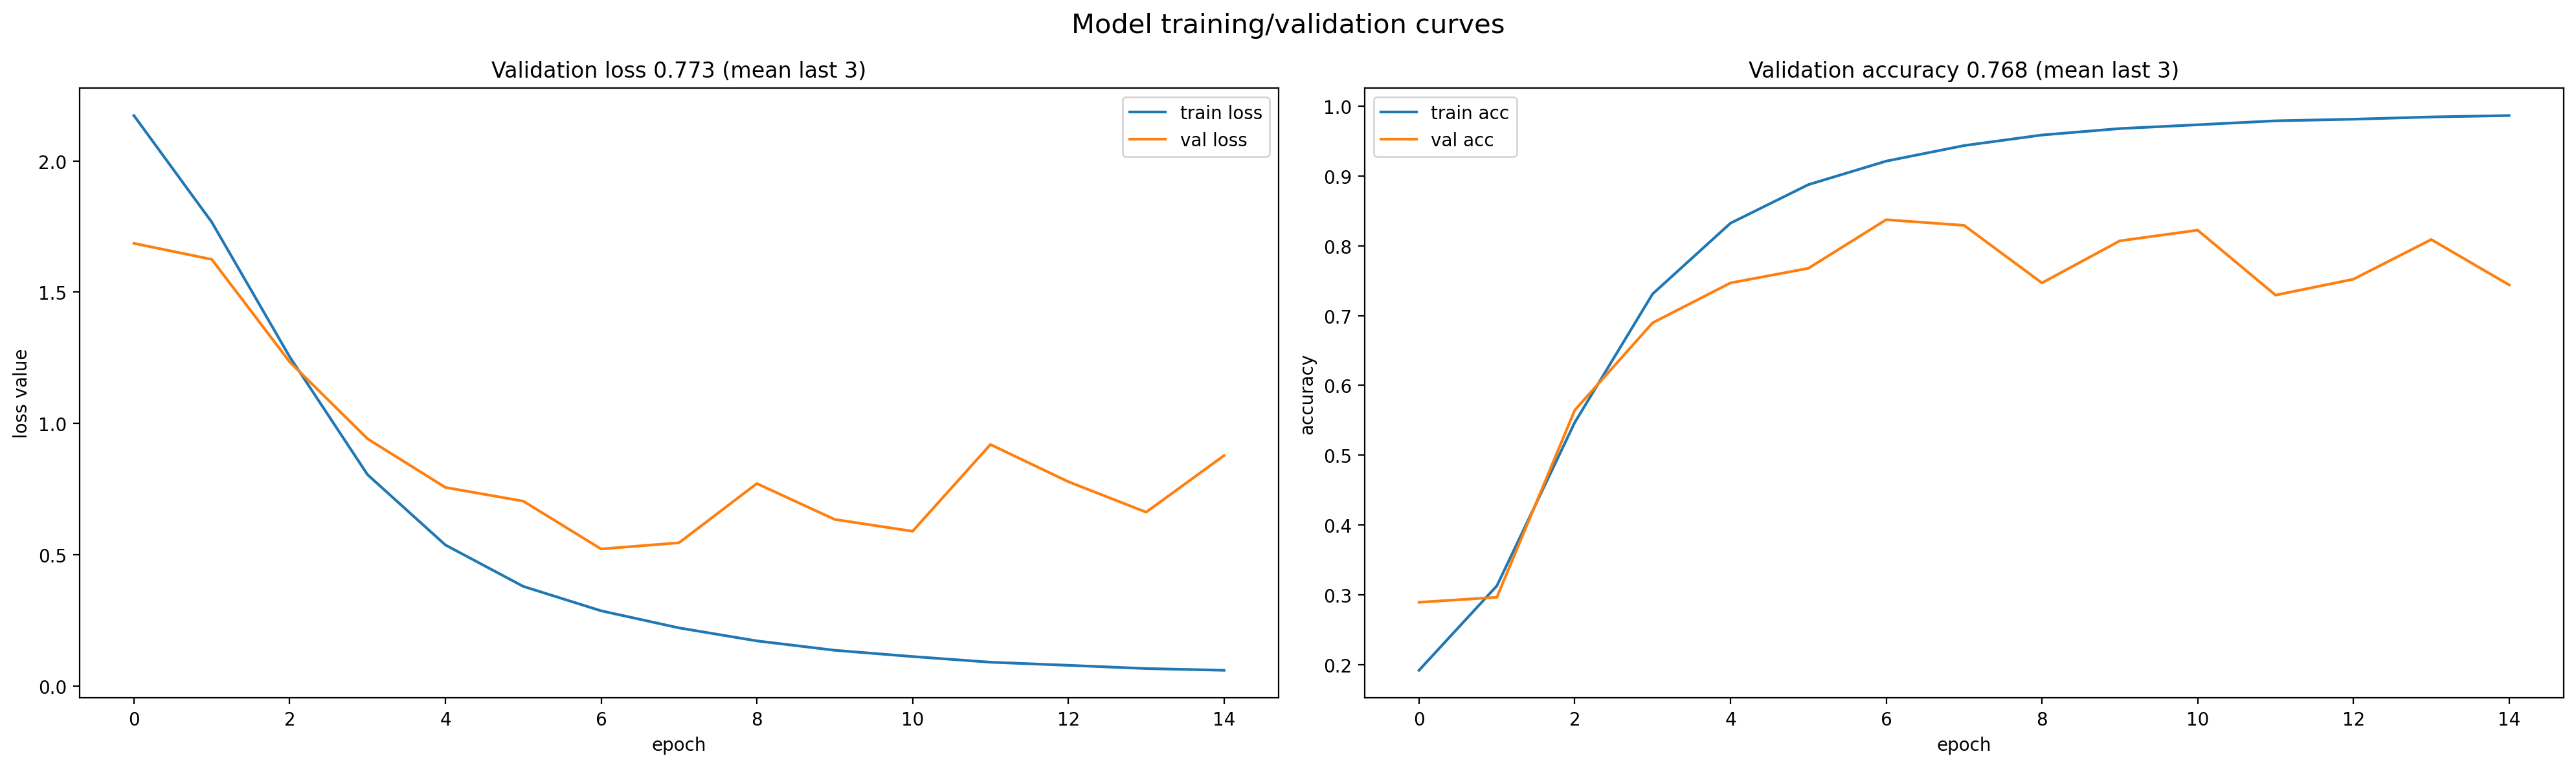

In [41]:
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Model training/validation curves', size=15)

# Plot loss values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.show()

In [42]:
test_loss, test_acc = model.evaluate(X_va_seq,y_va)

print('Validation loss:', test_loss)
print('Validation accuracy:', test_acc)

100/100 [==============================] - 12s 94ms/step - loss: 0.8779 - acc: 0.7441
Validation loss: 0.8778518438339233
Validation accuracy: 0.7440624833106995


In [43]:
# Compute validation set predictions
pred = [np.argmax(i) for i in model.predict(X_va_seq)]

100/100 [==============================] - 11s 91ms/step


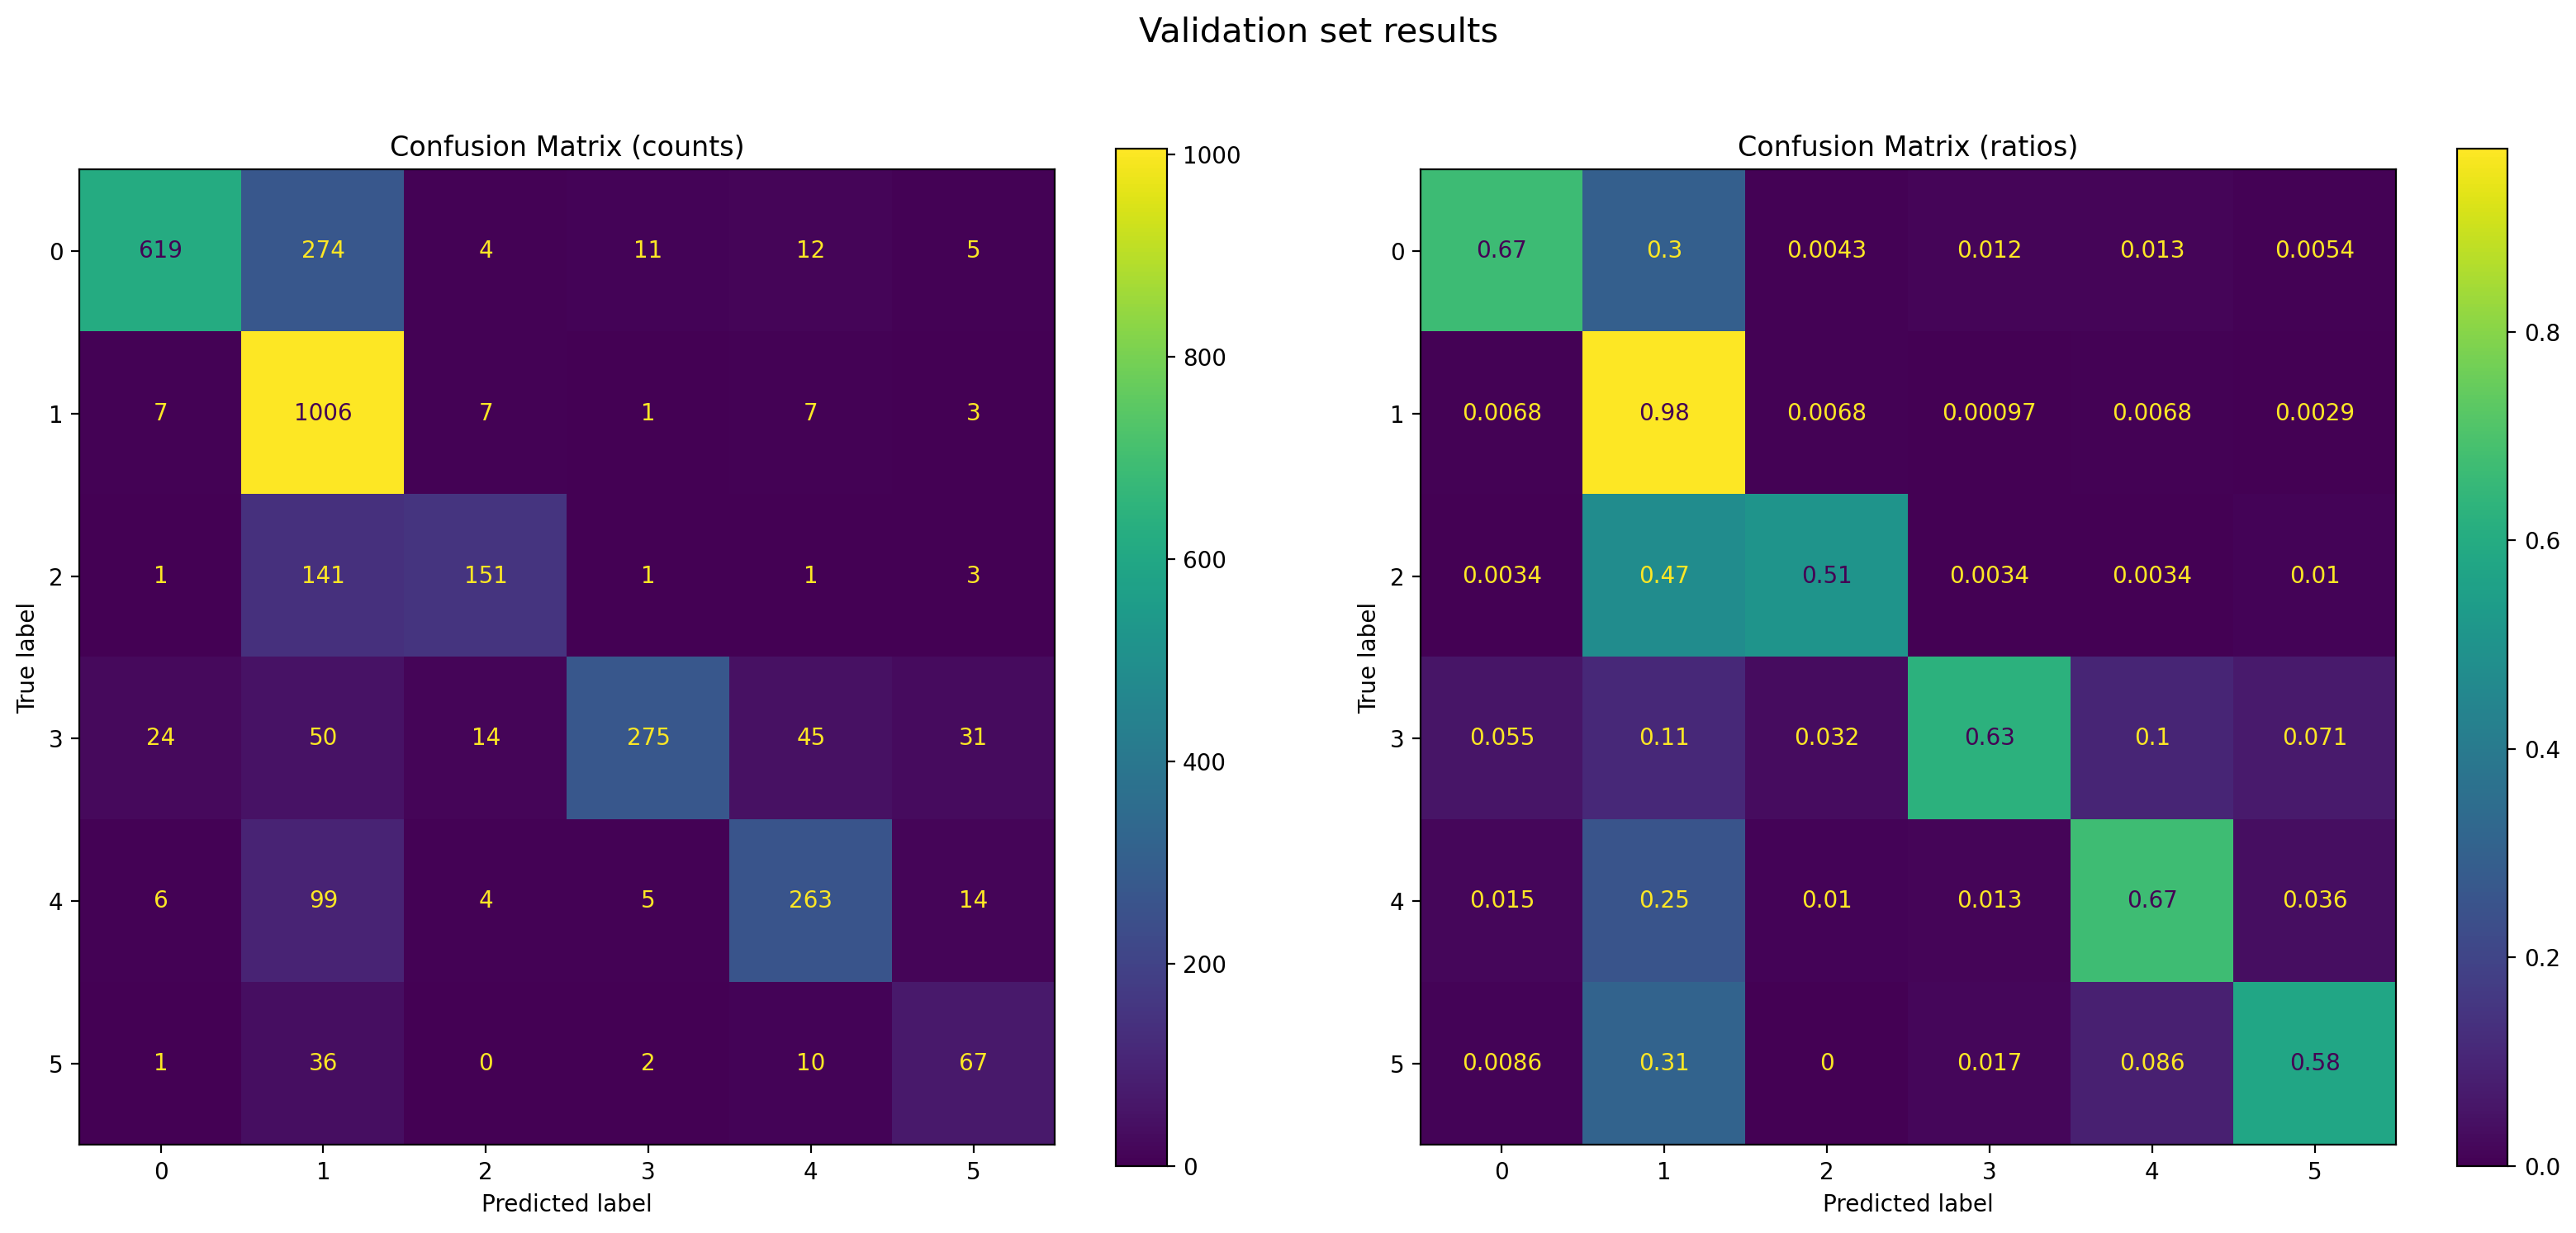

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for raw counts
cm_raw = confusion_matrix(y_va, pred)

# Compute confusion matrix for normalized ratios
cm_norm = confusion_matrix(y_va, pred, normalize='true')

# Create confusion matrix plots
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={"width_ratios": [10, 10], "wspace": 0.1}, subplot_kw={"aspect":"equal"})
plt.suptitle('Validation set results', size = 15)
disp_raw.plot(ax=axs[0])
axs[0].set_title('Confusion Matrix (counts)')
disp_norm.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix (ratios)')
plt.show()


# Make predictions

In [49]:
# Compute test set predictions
predictions = [np.argmax(i) for i in model.predict(X_te_seq)]
    
# Create a new DataFrame to merge text ids and the model predictions
submission = pd.DataFrame({'clean_text': test.clean_text, 'label': predictions})

# Check few random entries
submission.sample(10)

63/63 [==============================] - 6s 93ms/step


,clean_text,label
285,feel thrilled three distinguished individuals,1
752,knew except lost girly feeling gained graceful...,1
1033,feel aggravated annoyed visits,3
1676,inspired looking ideas images feel dont apprec...,1
600,learning deal nausea amp manage unpleasantness...,1
1826,always feel like amazing style days choose com...,1
736,want feel less stressed,0
614,ive learned angels earth feel feel stand lovin...,2
1995,keep feeling like someone unkind wrong think g...,3
459,decent article knew likely good information in...,3


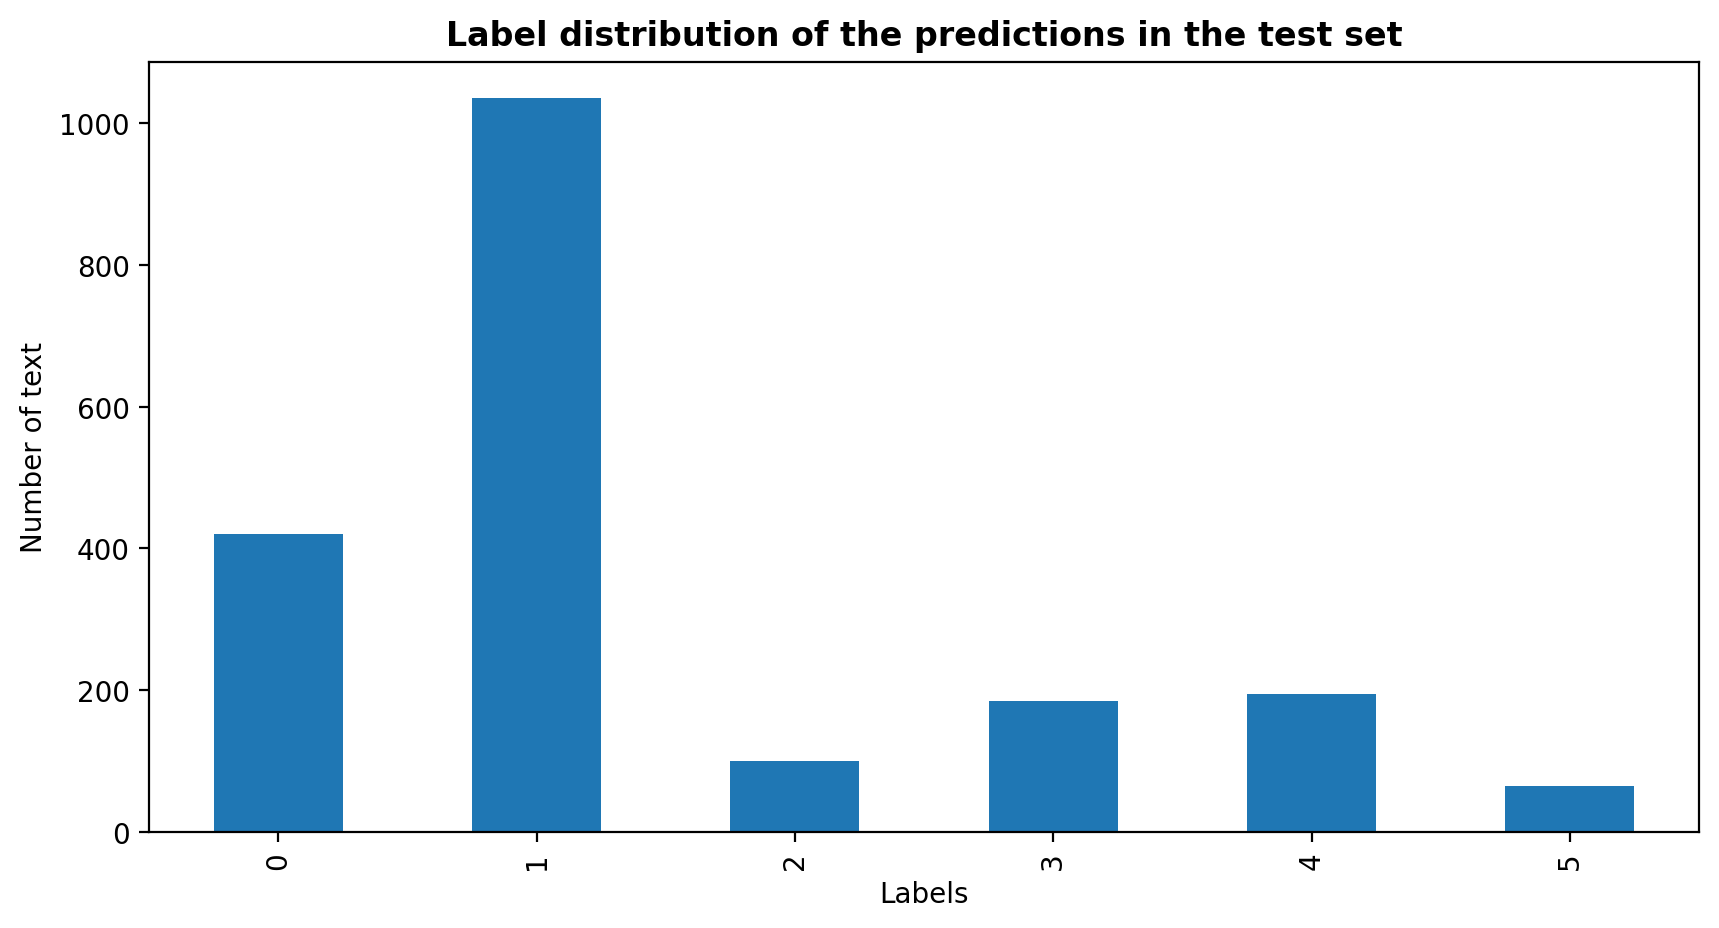

In [50]:
# Check target balance
submission['label'].value_counts().sort_index().plot.bar(figsize=(10,5))
plt.title('Label distribution of the predictions in the test set', fontweight="bold")
plt.xlabel('Labels')
plt.ylabel('Number of text')
plt.show()

In [51]:
# Export predictions
submission.to_csv("submission.csv", index=None)